# Woodbine Racetrack Analysis

Our goal is to use a neural network to analyze historical horse racing data from the Woodbine Racetrack in order to predict which horse will win in a race.

Our process will be to use a sequential NN to classify the winner of a race, then compare the model's accuracy to traditional
machine learning models.

Our subgoal is to retire off the winnings we make from using our algorithm to bet on horses at the Woodbine Racetrack!

## Import Libraries and Data

In [1]:
#Imported libraries
import pandas as pd
import numpy as np
import glob
import os
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score

%matplotlib inline
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import pylab as py
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#Our dataset is only 4k records, with 27 columns
df = pd.read_csv('woodbine_horses.csv')

# Data Exploration

In [7]:
df.shape

(4370, 27)

In [4]:
print(df.columns)

Index(['track', 'card_id', 'race_date', 'breed', 'name', 'weight', 'age',
       'sex', 'meds_and_equip', 'jockey', 'dollar_odds', 'program_number',
       'post_position', 'claim_price', 'start_position', 'finish_position',
       'finish_time', 'speed_rating', 'trainer', 'owner', 'win_payoff',
       'place_payoff', 'show_payoff', 'weather', 'distance', 'race_type',
       'track_conditions'],
      dtype='object')


In [5]:
# Let's start looking through the data
df.head()

,track,card_id,race_date,breed,name,weight,age,sex,meds_and_equip,jockey,dollar_odds,program_number,post_position,claim_price,start_position,finish_position,finish_time,speed_rating,trainer,owner,win_payoff,place_payoff,show_payoff,weather,distance,race_type,track_conditions
0,WO,D,2015-06-20 00:00:00,TB,Madam Premier,119,4,M,Lb,S Ryan,7.20,1.0,1,9500,5.0,5.0,0.0,44.0,O'Keefe Thomas,Emily Anne Walker,0.0,0.0,0.0,Cloudy,900.0,Claiming,FT
1,WO,D,2015-07-19 00:00:00,TB,Notion Sonet,118,3,C,L,L Contreras,12.10,4.0,4,0,10.0,4.0,0.0,96.0,Carroll Josie,Ivan Dalos,0.0,0.0,0.0,Cloudy,650.0,Allowance,FT
2,WO,D,2015-07-25 00:00:00,TB,Big Red Bugsy,121,5,G,L,S R Bahen,24.75,6.0,6,20000,10.0,5.0,0.0,83.0,Fournier Mark,"Carruthers, Carruthers, Carruthers, Carruthers...",0.0,0.0,0.0,Cloudy,700.0,Claiming,FT
3,WO,D,2015-08-14 00:00:00,TB,Lillz Pearl,121,5,G,Lb,J McAleney,3.80,3.0,3,0,7.0,2.0,0.0,88.0,Singh Ricky,Ricky Singh,0.0,5.7,3.3,Clear,500.0,Allowance,FT
4,WO,D,2015-08-29 00:00:00,TB,Sweet Rose,121,4,F,NaN,L Contreras,2.95,3.0,3,0,4.0,3.0,0.0,86.0,Attard Sid C,Stronach Stables,0.0,0.0,3.1,Cloudy,500.0,Allowance,FT


In [13]:
# Many of these columns only have one value - we will drop these.
print(len(df['track'].value_counts()))
print(len(df['card_id'].value_counts()))
print(len(df['breed'].value_counts()))

1
1
1


In [25]:
# We are looking at data from 205 different race dates
print(df['race_date'].value_counts())    
  
race_date = df['race_date'].value_counts().rename_axis('values').reset_index(name='counts')
print (race_date)

2016-10-16 00:00:00    106
2016-09-25 00:00:00     92
2016-10-29 00:00:00     89
2016-10-09 00:00:00     89
2016-09-17 00:00:00     88
                      ... 
2016-05-19 00:00:00      1
2016-05-15 00:00:00      1
2016-05-14 00:00:00      1
2016-05-13 00:00:00      1
2017-04-05 00:00:00      1
Name: race_date, Length: 205, dtype: int64
                  values  counts
0    2016-10-16 00:00:00     106
1    2016-09-25 00:00:00      92
2    2016-10-29 00:00:00      89
3    2016-10-09 00:00:00      89
4    2016-09-17 00:00:00      88
..                   ...     ...
200  2016-05-19 00:00:00       1
201  2016-05-15 00:00:00       1
202  2016-05-14 00:00:00       1
203  2016-05-13 00:00:00       1
204  2017-04-05 00:00:00       1

[205 rows x 2 columns]


In [ ]:
# Which horses are racing?
df['name'].value_counts()

Primordia               9
Cape Zavata             8
Foxy Phill              8
Erie Breeze             8
Buckden House           8
                       ..
dq-Too Many Egbert's    1
Nezwaah (GB)            1
Bangla Dancer           1
Uncle Shaggy            1
My Cantata              1
Name: name, Length: 1600, dtype: int64

### TExploratons of the metrics of the horses

For instance, weight, equipment, which jockey was racing, the track conditions, and more.

    values  counts
0      119    1119
1      121    1064
2      118     587
3      120     417
4        0     317
5      117     237
6      123     198
7      116     162
8      115     100
9      114      83
10     122      44
11     124      15
12     113      13
13     126      12
14     112       1
15     109       1


Text(0, 0.5, 'Counts')

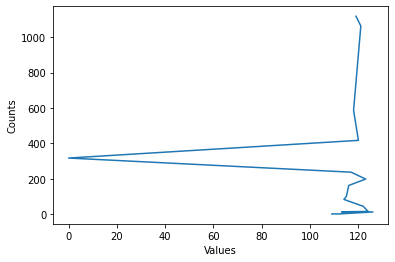

In [ ]:
df['weight'].value_counts()

weight = df['weight'].value_counts().rename_axis('values').reset_index(name='counts')
print (weight)

plt.plot(weight['values'], weight['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0        3    1181
1        4    1023
2        2     674
3        5     562
4        6     331
5        0     317
6        7     208
7        8      44
8        9      23
9       10       4
10      11       3


Text(0, 0.5, 'Counts')

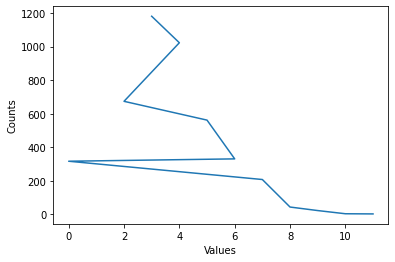

In [ ]:
df['age'].value_counts()

age = df['age'].value_counts().rename_axis('values').reset_index(name='counts')
print (age)

plt.plot(age['values'], age['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

  values  counts
0      G    1824
1      F    1060
2      M     853
3      C     184
4      H     111
5      R      21


Text(0, 0.5, 'Counts')

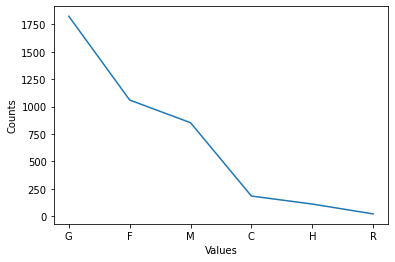

In [ ]:
df['sex'].value_counts()

sex = df['sex'].value_counts().rename_axis('values').reset_index(name='counts')
print (sex)

plt.plot(sex['values'], sex['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

   values  counts
0      Lb    1709
1       L    1533
2     Lbf     243
3      Lf     213
4       b     131
5      Ly      14
6      Lv      13
7       y      10
8      bf       8
9     Lby       6
10      f       5
11    Lvf       5
12    Lfy       5
13     by       4
14      v       4
15   Lbfy       1
16    bfy       1
17   Lbfr       1
18    Lbr       1


Text(0, 0.5, 'Counts')

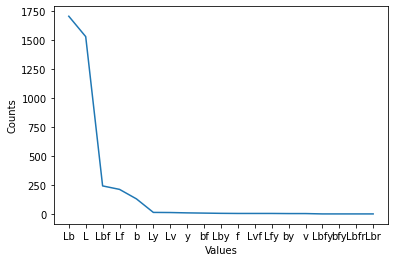

In [ ]:
df['meds_and_equip'].value_counts()

meds_and_equip = df['meds_and_equip'].value_counts().rename_axis('values').reset_index(name='counts')
print (meds_and_equip)

plt.plot(meds_and_equip['values'], meds_and_equip['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

           values  counts
0    E R Da Silva     285
1   R M Hernandez     284
2   L   Contreras     258
3   G   Boulanger     249
4       D   Moran     240
..            ...     ...
81      W T Buick       1
82    C P DeCarlo       1
83     O   Murphy       1
84    P   Morales       1
85     H F Newell       1

[86 rows x 2 columns]


Text(0, 0.5, 'Counts')

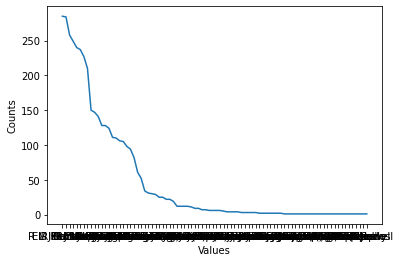

In [ ]:
df['jockey'].value_counts()

jockey = df['jockey'].value_counts().rename_axis('values').reset_index(name='counts')
print (jockey)

plt.plot(jockey['values'], jockey['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

      values  counts
0       0.00     319
1       2.65      26
2       3.00      25
3       2.80      24
4       2.20      22
...      ...     ...
1207   79.35       1
1208  158.15       1
1209   19.20       1
1210   76.35       1
1211   25.40       1

[1212 rows x 2 columns]


Text(0, 0.5, 'Counts')

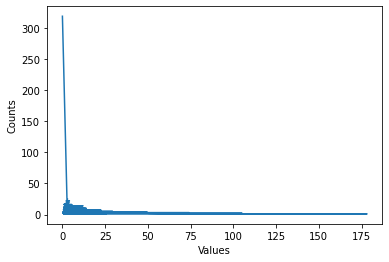

In [ ]:
df['dollar_odds'].value_counts()

dollar_odds = df['dollar_odds'].value_counts().rename_axis('values').reset_index(name='counts')
print (dollar_odds)

plt.plot(dollar_odds['values'], dollar_odds['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0      5.0     446
1      2.0     443
2      1.0     436
3      4.0     435
4      3.0     433
5      6.0     430
6      7.0     383
7      8.0     323
8      9.0     240
9     10.0     161
10    11.0     121
11    12.0      90
12    13.0      55
13    14.0      42
14    15.0      10
15    16.0       5


Text(0, 0.5, 'Counts')

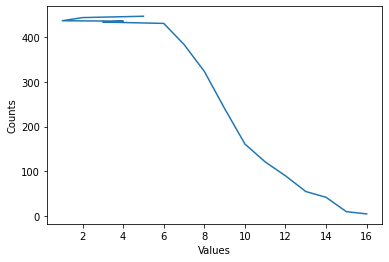

In [ ]:
df['program_number'].value_counts()

program_number = df['program_number'].value_counts().rename_axis('values').reset_index(name='counts')
print (program_number)

plt.plot(program_number['values'], program_number['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0        1     461
1        2     459
2        3     457
3        4     455
4        5     454
5        6     448
6        7     383
7        0     317
8        8     313
9        9     228
10      10     144
11      11     107
12      12      78
13      13      40
14      14      26


Text(0, 0.5, 'Counts')

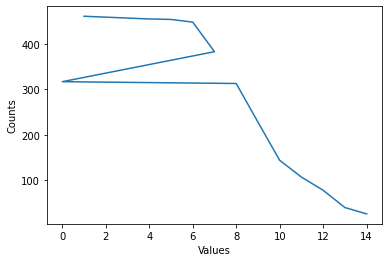

In [ ]:
df['post_position'].value_counts()

post_position = df['post_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (post_position)

plt.plot(post_position['values'], post_position['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0        0    1859
1     9500     475
2    20000     270
3    10000     264
4    40000     245
5     7500     172
6    19000     135
7     8000     121
8     6000     110
9    37500     105
10   12500      87
11   25000      85
12   11500      82
13   32000      67
14   16000      64
15   15000      54
16    6250      45
17   30000      33
18   60000      30
19   62500      20
20   23500      20
21   75000      12
22   50000       9
23   47500       4
24   72500       1
25   80000       1


Text(0, 0.5, 'Counts')

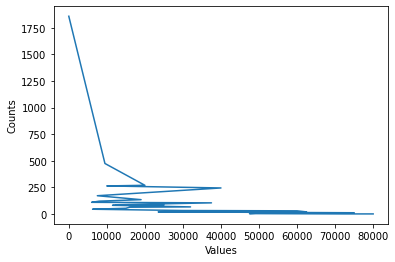

In [ ]:
df['claim_price'].value_counts()

claim_price = df['claim_price'].value_counts().rename_axis('values').reset_index(name='counts')
print (claim_price)

plt.plot(claim_price['values'], claim_price['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0      1.0     464
1      3.0     458
2      4.0     456
3      2.0     451
4      5.0     438
5      6.0     432
6      0.0     409
7      7.0     373
8      8.0     300
9      9.0     211
10    10.0     139
11    11.0     102
12    12.0      72
13    13.0      39
14    14.0      26


Text(0, 0.5, 'Counts')

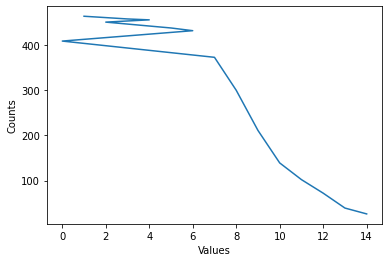

In [ ]:
df['start_position'].value_counts()

start_position = df['start_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (start_position)

plt.plot(start_position['values'], start_position['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0      3.0     470
1      2.0     466
2      1.0     464
3      4.0     457
4      5.0     454
5      6.0     444
6      7.0     383
7      0.0     317
8      8.0     305
9      9.0     227
10    10.0     139
11    11.0     104
12    12.0      73
13    13.0      41
14    14.0      26


Text(0, 0.5, 'Counts')

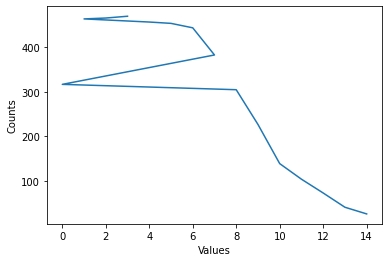

In [ ]:
df['finish_position'].value_counts()

finish_position = df['finish_position'].value_counts().rename_axis('values').reset_index(name='counts')
print (finish_position)

plt.plot(finish_position['values'], finish_position['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

In [ ]:
#Unnecessary feature
df['finish_time'].value_counts()

0.0    4053
Name: finish_time, dtype: int64

     values  counts
0      68.0     119
1      80.0     117
2      72.0     113
3      69.0     112
4      75.0     111
..      ...     ...
113    22.0       1
114    19.0       1
115    17.0       1
116    27.0       1
117   107.0       1

[118 rows x 2 columns]


Text(0, 0.5, 'Counts')

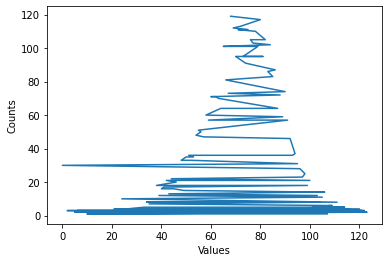

In [ ]:
# So far this is the only feature showing what looks like a normal distribution.  Those ~30 value counts of 0 are likely null values
df['speed_rating'].value_counts()

speed_rating = df['speed_rating'].value_counts().rename_axis('values').reset_index(name='counts')
print (speed_rating)

plt.plot(speed_rating['values'], speed_rating['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

                 values  counts
0          Casse Mark E     158
1          Attard Kevin     106
2    De Paulo Michael P      98
3       McKnight Norman      94
4       Doyle Michael J      88
..                  ...     ...
280  Benson Liam Daniel       1
281     Connelly Teresa       1
282     Hickst Waldemar       1
283     Concessi Armand       1
284        Smith Andrew       1

[285 rows x 2 columns]


Text(0, 0.5, 'Counts')

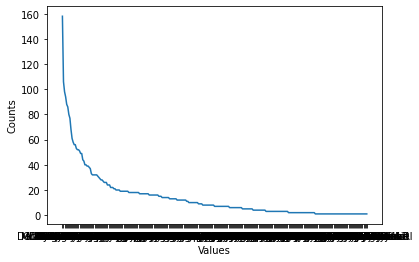

In [ ]:
df['trainer'].value_counts()

trainer = df['trainer'].value_counts().rename_axis('values').reset_index(name='counts')
print (trainer)

plt.plot(trainer['values'], trainer['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

                                           values  counts
0                                 Colebrook Farms      62
1                               Bruno Schickedanz      58
2                          Joey Gee Thoroughbreds      47
3                                   Tucci Stables      45
4                               Chiefswood Stable      45
..                                            ...     ...
859                              Silver King Farm       1
860  Sheikh Ahmed Al Maktoum Lessee and Godolphin       1
861                             Golden Eagle Farm       1
862               Ramsey, Kenneth L. and Sarah K.       1
863                           JMC's Racing Stable       1

[864 rows x 2 columns]


Text(0, 0.5, 'Counts')

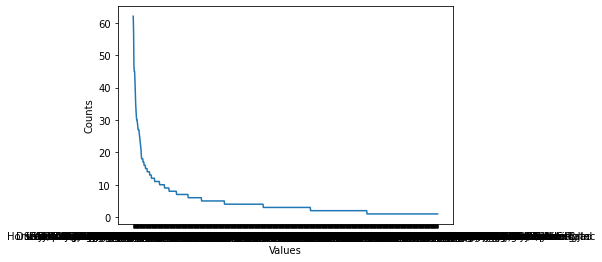

In [ ]:
df['owner'].value_counts()

owner = df['owner'].value_counts().rename_axis('values').reset_index(name='counts')
print (owner)

plt.plot(owner['values'], owner['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

     values  counts
0       0.0    3906
1       5.5       9
2       6.5       9
3       4.7       8
4       5.7       8
..      ...     ...
189    46.0       1
190    44.8       1
191    35.8       1
192    14.0       1
193    19.5       1

[194 rows x 2 columns]


Text(0, 0.5, 'Counts')

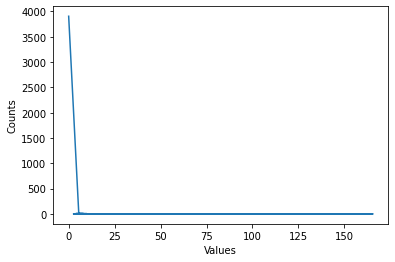

In [ ]:
df['win_payoff'].value_counts()

win_payoff = df['win_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (win_payoff)

plt.plot(win_payoff['values'], win_payoff['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

     values  counts
0       0.0    3440
1       3.0      29
2       2.9      29
3       3.6      28
4       3.3      26
..      ...     ...
152    14.8       1
153    25.8       1
154    22.3       1
155    14.7       1
156    27.7       1

[157 rows x 2 columns]


Text(0, 0.5, 'Counts')

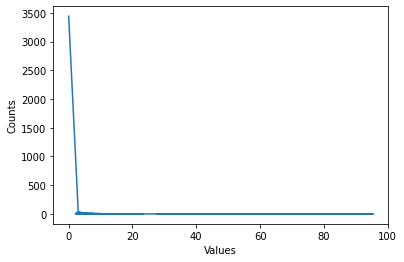

In [ ]:
df['place_payoff'].value_counts()

place_payoff = df['place_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (place_payoff)

plt.plot(place_payoff['values'], place_payoff['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

     values  counts
0       0.0    2994
1       2.1      83
2       2.9      61
3       2.8      59
4       2.6      57
..      ...     ...
112    11.1       1
113    12.9       1
114    19.8       1
115    14.6       1
116    44.9       1

[117 rows x 2 columns]


Text(0, 0.5, 'Counts')

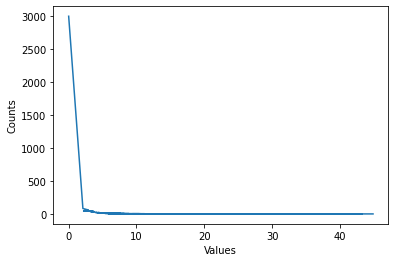

In [ ]:
df['show_payoff'].value_counts()

show_payoff = df['show_payoff'].value_counts().rename_axis('values').reset_index(name='counts')
print (show_payoff)

plt.plot(show_payoff['values'], show_payoff['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0   Cloudy    3145
1  Showery     544
2    Clear     425
3    Rainy     231
4  Snowing      25


Text(0, 0.5, 'Counts')

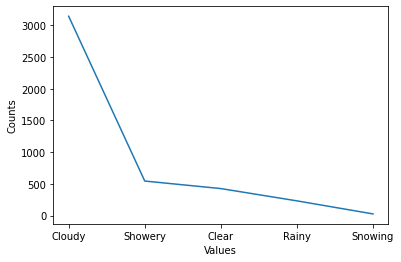

In [ ]:
df['weather'].value_counts()

weather = df['weather'].value_counts().rename_axis('values').reset_index(name='counts')
print (weather)

plt.plot(weather['values'], weather['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

    values  counts
0    850.0    1083
1    600.0     920
2    700.0     788
3    650.0     525
4    500.0     386
5    900.0     343
6    800.0     152
7    550.0      78
8   1000.0      39
9   1200.0      25
10  1400.0      14
11  1500.0       9
12  1300.0       8


Text(0, 0.5, 'Counts')

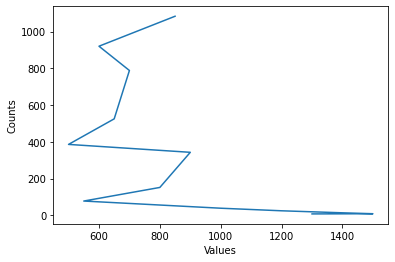

In [ ]:
df['distance'].value_counts()

distance = df['distance'].value_counts().rename_axis('values').reset_index(name='counts')
print (distance)

plt.plot(distance['values'], distance['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

                        values  counts
0                     Claiming    1756
1              Maiden Claiming     797
2                    Allowance     600
3        Maiden Special Weight     424
4                       Stakes     365
5  Allowance Optional Claiming     188
6     Maiden Optional Claiming     140
7           Starters Allowance      85
8            Optional Claiming      15


Text(0, 0.5, 'Counts')

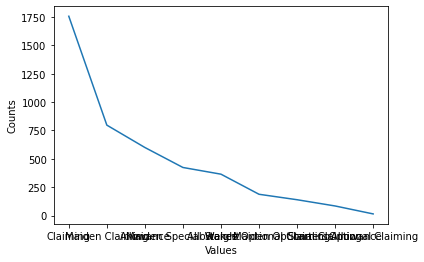

In [ ]:
df['race_type'].value_counts()

race_type = df['race_type'].value_counts().rename_axis('values').reset_index(name='counts')
print (race_type)

plt.plot(race_type['values'], race_type['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

  values  counts
0     FT    3771
1     GD     340
2     FM     252
3     YL       7


Text(0, 0.5, 'Counts')

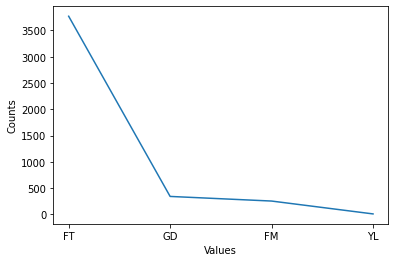

In [ ]:
df['track_conditions'].value_counts()

track_conditions = df['track_conditions'].value_counts().rename_axis('values').reset_index(name='counts')
print (track_conditions)

plt.plot(track_conditions['values'], track_conditions['counts'])
plt.xlabel('Values')
plt.ylabel('Counts')

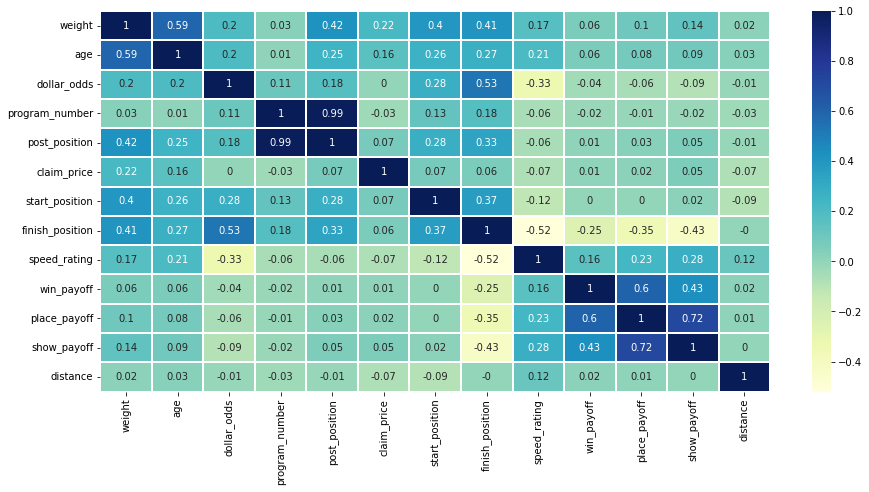

In [ ]:
heatmap_columns = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
matrix = heatmap_columns.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

#Lets see the correlation between features in our dataset

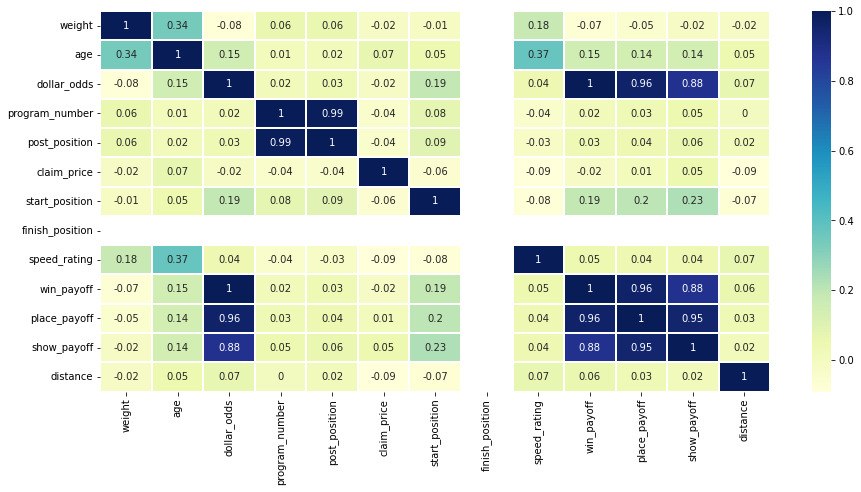

In [ ]:
heatmap_columns2 = df.drop(['race_date','track', 'card_id', 'breed', 'finish_time'], axis=1)
heatmap_columns2 = heatmap_columns[heatmap_columns.apply(lambda x: x["finish_position"] == 1, axis=1)]
matrix = heatmap_columns2.corr().round(2)
f, ax = plt.subplots(figsize =(15, 7))
sns.heatmap(matrix, annot=True,linewidths = 0.1,cmap ="YlGnBu")
plt.show()

#Lets see the correlation between features in our dataset, only for the winners, or finish position 1

3234.5166666666664

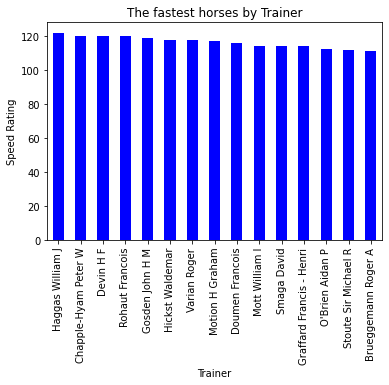

In [ ]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Trainer')
plt.xlabel('Trainer') 
plt.ylabel('Speed Rating')

df.groupby('trainer').mean()['speed_rating'].sort_values(ascending=False).head(30).sum()

749.9143600431051

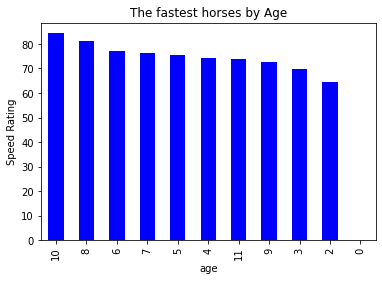

In [ ]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('The fastest horses by Age')
plt.xlabel('age') 
plt.ylabel('Speed Rating')

df.groupby('age').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()


It looks like horses with more experience are faster, and the preferable range of ages are from 6 to 10 years old.

909.0339789969942

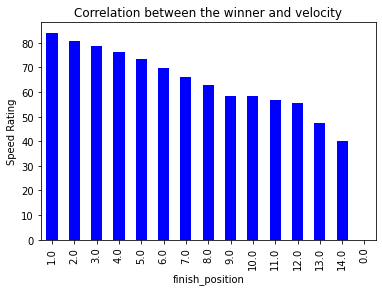

In [ ]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between the winner and velocity')
plt.xlabel('finish_position') 
plt.ylabel('Speed Rating')

df.groupby('finish_position').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

# As we can see, the fastest horse is always the winner (which we would expect).

1120.7705220738842

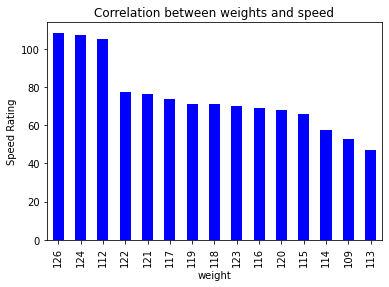

In [ ]:
fig, ax = plt.subplots()
df.sort_values('speed_rating')
df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).plot(kind = 'bar', ax = ax, color = 'blue')
plt.title('Correlation between weights and speed')
plt.xlabel('weight') 
plt.ylabel('Speed Rating')

df.groupby('weight').mean()['speed_rating'].sort_values(ascending=False).head(15).sum()

#It looks like the weight is really important for the wiinner, as the weightest horses are also the fastest ones, whith some small exceptions.

# Data Cleaning

In [ ]:
#First step is to remove all unnecessary columns with no information
df = df.drop(['track', 'card_id', 'breed', 'finish_time'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4370 non-null   object 
 1   name              4370 non-null   object 
 2   weight            4370 non-null   int64  
 3   age               4370 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4370 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4370 non-null   int64  
 10  claim_price       4370 non-null   int64  
 11  start_position    4370 non-null   float64
 12  finish_position   4370 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4370 non-null   float64


In [ ]:
# The meds and equipment feature is missing some values.  Looked up what this code means from woodbine's horse program,
# and 'L' represents no equipment.  Changed all Nulls to L'''
df['meds_and_equip'].fillna(value='L')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4370 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4370 non-null   object 
 1   name              4370 non-null   object 
 2   weight            4370 non-null   int64  
 3   age               4370 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4370 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4370 non-null   int64  
 10  claim_price       4370 non-null   int64  
 11  start_position    4370 non-null   float64
 12  finish_position   4370 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4370 non-null   float64


In [ ]:
# Upon review there are numerous records with missing values, these records only include basic information like the horses name
# making them unsuitable for our model
df.dropna(subset = ["trainer"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  finish_position   4053 non-null   float64
 13  speed_rating      4053 non-null   float64
 14  trainer           4053 non-null   object 
 15  owner             4053 non-null   object 
 16  win_payoff        4053 non-null   float64


In [ ]:
#Created my features and label
Y = df[['finish_position']]
X = df.drop(['finish_position'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   race_date         4053 non-null   object 
 1   name              4053 non-null   object 
 2   weight            4053 non-null   int64  
 3   age               4053 non-null   int64  
 4   sex               4053 non-null   object 
 5   meds_and_equip    3907 non-null   object 
 6   jockey            4053 non-null   object 
 7   dollar_odds       4053 non-null   float64
 8   program_number    4053 non-null   float64
 9   post_position     4053 non-null   int64  
 10  claim_price       4053 non-null   int64  
 11  start_position    4053 non-null   float64
 12  speed_rating      4053 non-null   float64
 13  trainer           4053 non-null   object 
 14  owner             4053 non-null   object 
 15  win_payoff        4053 non-null   float64
 16  place_payoff      4053 non-null   float64


In [ ]:
#One hot encoded all categorical features 

encoder = LabelEncoder()
encoder.fit(X['race_date'])
X['race_date'] = encoder.transform(X['race_date'])

#Creating dummies for categorical names
X_dummies = pd.get_dummies(X[['name']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('name', axis=1, inplace=True)

#Creating dummies for categorical sex
X_dummies = pd.get_dummies(X[['sex']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('sex', axis=1, inplace=True)

#Creating dummies for meds and equipment
X_dummies = pd.get_dummies(X[['meds_and_equip']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('meds_and_equip', axis=1, inplace=True)

#Creating dummies for jockey
X_dummies = pd.get_dummies(X[['jockey']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('jockey', axis=1, inplace=True)

#Creating dummies for trainer
X_dummies = pd.get_dummies(X[['trainer']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('trainer', axis=1, inplace=True)

#Creating dummies for owner
X_dummies = pd.get_dummies(X[['owner']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('owner', axis=1, inplace=True)

#Creating dummies for weather
X_dummies = pd.get_dummies(X[['weather']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('weather', axis=1, inplace=True)

#Creating dummies for race type
X_dummies = pd.get_dummies(X[['race_type']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('race_type', axis=1, inplace=True)

#Creating dummies for track conditions
X_dummies = pd.get_dummies(X[['track_conditions']])
X = pd.concat([X,X_dummies], axis=1)
X.drop('track_conditions', axis=1, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4053 entries, 0 to 4369
Columns: 2855 entries, race_date to track_conditions_YL
dtypes: float64(8), int32(1), int64(4), uint8(2842)
memory usage: 11.4 MB


In [ ]:
#Merged all the non-winning horses to a single category, we will only be predicting first place
Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])
Y = Y.astype(str)
Y_dummies = pd.get_dummies(Y[['finish_position']])
Y = pd.concat([Y,Y_dummies], axis=1)
Y.drop('finish_position', axis=1, inplace=True)
Y.head()

C:\Users\Mike\AppData\Local\Temp/ipykernel_11252/263452758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['finish_position'] = np.where(Y['finish_position'] > 1, 2, Y['finish_position'])


,finish_position_1.0,finish_position_2.0
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [ ]:
#The next step is to standardize our data (changing the values to between 0 and 1)
from sklearn.preprocessing import StandardScaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# Model Building

### Highest Accuracy Model

In [ ]:
#Train and test splitting the data
train_x, test_x, train_y, test_y = model_selection.train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [ ]:
model = keras.Sequential(
    [
        layers.Dense(5000, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(40, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

In [ ]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

In [ ]:
checkpointer = ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horserace.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 2s 9ms/step - loss: 0.5629 - accuracy: 0.8532 - val_loss: 0.4007 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weights.hdf5
Epoch 2/200
102/102 [==============================] - 1s 6ms/step - loss: 0.3355 - accuracy: 0.8862 - val_loss: 0.3288 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 1s 6ms/step - loss: 0.2966 - accuracy: 0.8868 - val_loss: 0.3329 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 1s 6ms/step - loss: 0.2271 - accuracy: 0.9004 - val_loss: 0.2993 - val_accuracy: 0.8816

Epoch 00004: val_accuracy improved from 0.87916 to 0.88163, saving model to weights.hdf5
Epoch 5/200
102/102 [==============================] - 1s 6ms/step - loss: 0.1867 - accuracy: 0.9204 - val_loss: 0.3252 - val_accuracy: 0.8

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 5000)              14280000  
_________________________________________________________________
dropout (Dropout)            (None, 5000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              5001000   
_________________________________________________________________
layer3 (Dense)               (None, 200)               200200    
_________________________________________________________________
layer4 (Dense)               (None, 40)                8040      
_________________________________________________________________
output1 (Dense)              (None, 2)                 82        
Total params: 19,489,322
Trainable params: 19,489,322
Non-trainable params: 0
____________________________________________

In [ ]:
y_pred = model.predict(test_x)

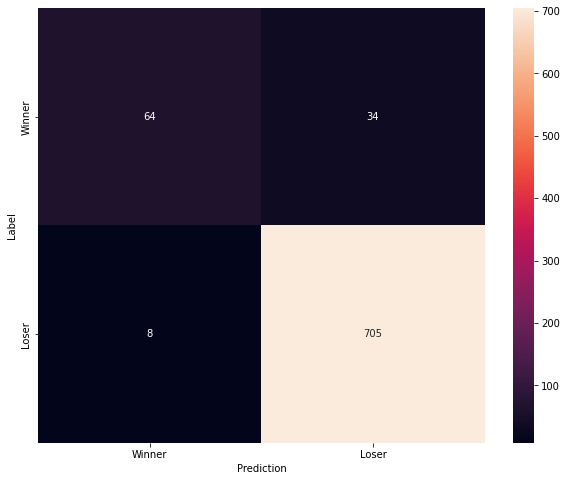

In [ ]:
%matplotlib inline
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

pred = y_pred.argmax(axis=1)
labels = test_y.values.argmax(axis=1)
title = np.array(['Winner', 'Loser'])

confusion_mtx = tf.math.confusion_matrix(labels, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=title,
            yticklabels=title,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
print("\nHistory Keys:\n")
print(history.history.keys())



History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


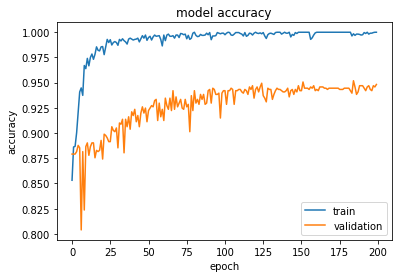

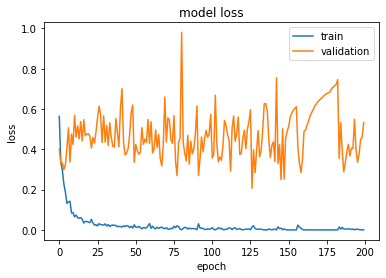

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Our final validation accuracy is 0.95314, but the smoothness of our learning rate and fluctuation of our loss is undesirable

# Hyperparameter Tuning

We tried different hyperparameters to try and increase our accuracy, this is a list of all the hyperparamenters we tuned:
    
    - changing the optimizer
    - adding and removing dropout layers
    - adding and removing dense layers, including the number of nodes
    - changing our activation functions
    - changing our final layer between softmax and sigmoid
    - attempting batch normalization

### Model 2

In [ ]:
#This is an example of our model where we changed the optimizer, changing adam's default values

model2 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
model2.compile(loss = 'categorical_crossentropy' , optimizer = optimizer2 , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model2.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev2.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 9ms/step - loss: 0.3957 - accuracy: 0.8482 - val_loss: 0.3680 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3516 - accuracy: 0.8871 - val_loss: 0.3683 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3525 - accuracy: 0.8871 - val_loss: 0.3678 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3513 - accuracy: 0.8871 - val_loss: 0.3737 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3518 - accuracy: 0.8871 - val_loss: 0.3666 - val_accuracy: 0.87920s - loss: 0.3543 - accuracy:

In [ ]:
y_pred2 = model2.predict(test_x)

In [ ]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
layer4 (Dense)               (None, 20)                4020      
_________________________________________________________________
output1 (Dense)              (None, 2)                 42        
Total params: 5,123,362
Trainable params: 5,123,362
Non-trainable params: 0
_________________________________________________________________


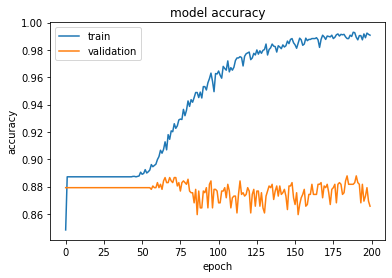

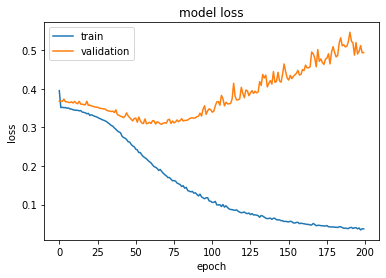

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we can see, there is fluctuation in our validation accuracy but no improvement

### Model 3

In [ ]:
#Variation 3, this model attempted to add many dropout layers

model3 = keras.Sequential(
    [
        layers.Dense(1400, activation='sigmoid', name='layer1'),
        layers.Dropout(0.2),
        layers.Dense(700, activation='relu', name='layer2'),
        layers.Dropout(0.2),
        layers.Dense(200, activation='relu', name='layer3'),
        layers.Dropout(0.2),
        layers.Dense(20, activation='relu', name='layer4'),
        layers.Dropout(0.2),
        layers.Dense(2, activation='softmax', name='output1'),
    ]
)

model3.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv2.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model3.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y)
                    )

model_name = "horseracev3.h5"
model.save(model_name)

Epoch 1/200
102/102 [==============================] - 1s 8ms/step - loss: 0.4456 - accuracy: 0.8717 - val_loss: 0.3758 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv2.hdf5
Epoch 2/200
102/102 [==============================] - 0s 5ms/step - loss: 0.4046 - accuracy: 0.8865 - val_loss: 0.3679 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3761 - accuracy: 0.8871 - val_loss: 0.3625 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.3721 - accuracy: 0.8868 - val_loss: 0.3607 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8871 - val_loss: 0.3493 - val_accuracy: 0.8792

Epoch 00005: val_accuracy d

In [ ]:
y_pred2 = model3.predict(test_x)

In [ ]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1400)              3998400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1400)              0         
_________________________________________________________________
layer2 (Dense)               (None, 700)               980700    
_________________________________________________________________
dropout_6 (Dropout)          (None, 700)               0         
_________________________________________________________________
layer3 (Dense)               (None, 200)               140200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
layer4 (Dense)               (None, 20)               

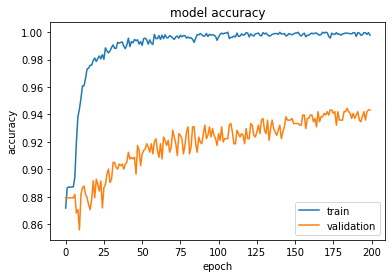

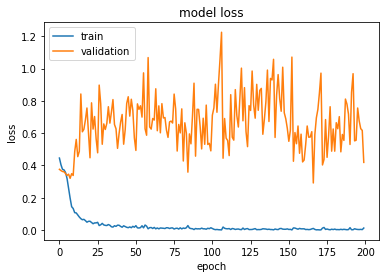

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#As we see overfitting in the previous model, we tried to increase even more our number of epochs to 200, and also we tried to add Dropouts to avoid a possible overfitting
# for this trial, the accuracyhas dropped slighly

In [ ]:
# Adding more dropout layers ultimately didn't help our overall accuracy, with slightly superior performance with less dropouts

### Model 4

In [ ]:
#In this attempt we tried a kernel regularization of l2 for batch normalization

model4 = keras.Sequential(
    [
        layers.Dense(2000, activation='sigmoid', name='layer1', kernel_regularizer='l2'), #addin kernel regularizer to try to decrease overfitting
        tf.keras.layers.BatchNormalization(), # this is batch normalization, another technique for improve overfiting training sets
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name='layer2', kernel_regularizer='l2',kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(300, activation='relu', name='layer3', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),
        layers.Dense(50, activation='relu', name='layer4', kernel_regularizer='l2'),
        tf.keras.layers.BatchNormalization(),     
        layers.Dense(2, activation='softmax', name='output1', kernel_regularizer='l2'),
    ]
)

model4.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

#model.summary() # model architecture
checkpointer = ModelCheckpoint(filepath="weightsv4.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True) # save model's best weights

history = model4.fit(
                    train_x, 
                    train_y, 
                    epochs=200,  
                    callbacks = [checkpointer], 
                    validation_data = (test_x, test_y), verbose=2
                    )

model_name = "horseracev4.h5"
model.save(model_name)

Epoch 1/200
102/102 - 3s - loss: 18.6405 - accuracy: 0.7147 - val_loss: 5.7823 - val_accuracy: 0.8792

Epoch 00001: val_accuracy improved from -inf to 0.87916, saving model to weightsv4.hdf5
Epoch 2/200
102/102 - 1s - loss: 2.9252 - accuracy: 0.8717 - val_loss: 1.4926 - val_accuracy: 0.8792

Epoch 00002: val_accuracy did not improve from 0.87916
Epoch 3/200
102/102 - 1s - loss: 1.0551 - accuracy: 0.8788 - val_loss: 0.9073 - val_accuracy: 0.8792

Epoch 00003: val_accuracy did not improve from 0.87916
Epoch 4/200
102/102 - 1s - loss: 0.7321 - accuracy: 0.8877 - val_loss: 0.7773 - val_accuracy: 0.8792

Epoch 00004: val_accuracy did not improve from 0.87916
Epoch 5/200
102/102 - 1s - loss: 0.6770 - accuracy: 0.8853 - val_loss: 0.7614 - val_accuracy: 0.8792

Epoch 00005: val_accuracy did not improve from 0.87916
Epoch 6/200
102/102 - 1s - loss: 0.5814 - accuracy: 0.8951 - val_loss: 0.6526 - val_accuracy: 0.8792

Epoch 00006: val_accuracy did not improve from 0.87916
Epoch 7/200
102/102 - 1s

In [ ]:
y_pred4 = model4.predict(test_x)

In [ ]:
print("\nHistory Keys:\n")
print(history.history.keys())


History Keys:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2000)              5712000   
_________________________________________________________________
batch_normalization (BatchNo (None, 2000)              8000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2000)              0         
_________________________________________________________________
layer2 (Dense)               (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
layer3 (Dense)               (None, 300)               300300    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)              

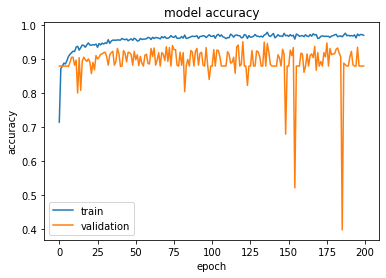

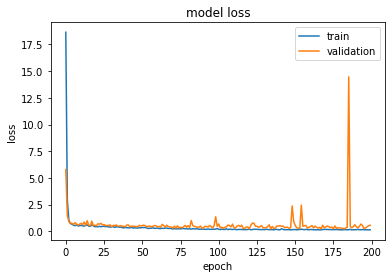

In [ ]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots() # open a new plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
#The final validation accuracy is comparable to our final model, but the large fluctuations in validation accuracy are undesirable.
#The model appears to struggle to learn fluctuates around a lower mean validation accuracy

# Comparison to Traditional ML Models

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#For traditional ML models we'll need only 1 array of values, 1st place of not.
Y_ml = Y['finish_position_1.0']

In [ ]:
# Training test split for machine learning algorithm
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(X,Y_ml,test_size = 0.2, random_state = 1)

In [ ]:
#Random Forest Classifier
model3 = RandomForestClassifier(max_depth=10)
model3.fit(train_X, train_Y)
y_pred = model3.predict(test_X)
cm3 = confusion_matrix(y_pred, test_Y)
total3=sum(sum(cm3))
Accuracy = (cm3[0,0]+cm3[1,1])/total4
Specificity = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print("Accuracy of  RFC :", Accuracy, "--Specificity of  RFC :", Specificity )

Accuracy of  RFC : 0.8914919852034525 --Specificity of  RFC : 0.8914919852034525


In [ ]:
#SVM Classifier
model4 = SVC(kernel='rbf')
model4.fit(train_X, train_Y)
y_pred = model4.predict(test_X)
cm4 = confusion_matrix(y_pred, test_Y)
total4=sum(sum(cm4))
Accuracy = (cm4[0,0]+cm4[1,1])/total4
Specificity = cm4[0,0]/(cm4[0,0]+cm4[0,1])
print("Accuracy of  SVM :", Accuracy, "--Specificity of  SVM :", Specificity )


Accuracy of  SVM : 0.8914919852034525 --Specificity of  SVM : 0.8914919852034525


In [ ]:
#  GaussianNB 
model5 = GaussianNB()
model5.fit(train_X, train_Y)
y_pred = model5.predict(test_X)
cm5 = confusion_matrix(y_pred, test_Y)
total5=sum(sum(cm5))
Accuracy = (cm5[0,0]+cm5[1,1])/total5
    
Specificity = cm5[0,0]/(cm5[0,0]+cm5[0,1])
Sensitivity = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print("Accuracy of  GaussianNB :", Accuracy, "--Sensitivity of  GaussianNB :", Sensitivity, "--Specificity of  GaussianNB :", Specificity )


Accuracy of  GaussianNB : 0.6905055487053021 --Sensitivity of  GaussianNB : 0.12442396313364056 --Specificity of  GaussianNB : 0.8973063973063973


In [ ]:
model6 = KNeighborsClassifier(n_neighbors=3)

model6.fit(train_X, train_Y)
 
# making predictions on the testing set
y_pred = model6.predict(test_X)
cm6 = confusion_matrix(y_pred, test_Y)
total6=sum(sum(cm6))
Accuracy = (cm6[0,0]+cm6[1,1])/total6
Specificity= cm6[0,0]/(cm6[0,0]+cm6[0,1])
Sensitivity = cm6[1,1]/(cm6[1,0]+cm6[1,1])
print("Accuracy of KNN:", Accuracy, "--Sensitivity of KNN:", Sensitivity, "--Specificity of KNN:", Specificity )

Accuracy of KNN: 0.8692971639950678 --Sensitivity of KNN: 0.2631578947368421 --Specificity of KNN: 0.8990944372574385


# Results
We were able to make a classifier that does a very good job with 95% accuracy, and it outperforms out attmepts at solving the same problem with classical machine learning models.

    -NN:   0.95314
    -RFC:  0.89149
    -SVMC: 0.89149
    -KNNC: 0.86929
    -GNB:  0.69050